In [1]:
%matplotlib inline

import seaborn as sns
import numpy as np
import numba

import matplotlib.pylab as plt
import matplotlib.cm as cm
from IPython.display import HTML

from tierpsy_features.velocities import get_velocity, get_relative_velocities, animate_velocity, \
_h_segment_position, _h_get_velocity

data = np.load('./data/worm_example.npz')

skeletons = data['skeleton']
dorsal_contour = data['dorsal_contour']
ventral_contour = data['ventral_contour']

contours = np.concatenate((dorsal_contour, ventral_contour[:, ::-1, :]), axis=1)
widths = data['widths']

print(contours.shape)

(7505, 98, 2)


Text(0.5,1,'Length')

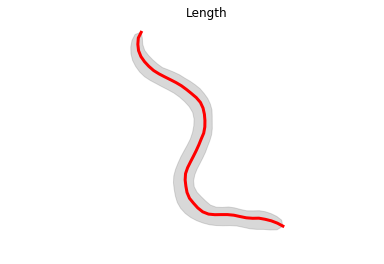

In [2]:
tt = 10

cc = contours[tt]
skel = skeletons[tt]

plt.plot(skel[:, 0], skel[:, 1], 'r', lw=3)
plt.fill(cc[:, 0], cc[:, 1], color='gray', alpha=0.3)
plt.axis('equal')
plt.axis('off')

plt.title('Length')

Text(0.5,1,'Area')

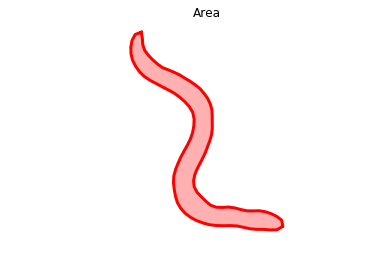

In [3]:
tt = 10

cc = contours[tt]
skel = skeletons[tt]
plt.plot(cc[:, 0], cc[:, 1], 'r', lw=3)
plt.fill(cc[:, 0], cc[:, 1], color='r', alpha=0.3)
plt.axis('equal')
plt.axis('off')

plt.title('Area')

Text(0.5,1,'Body Parts')

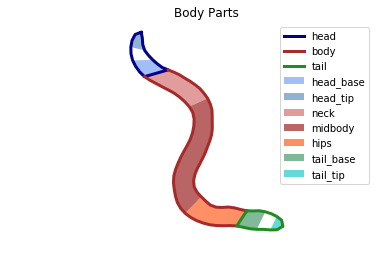

In [4]:
from tierpsy_features.helper import DataPartition

dp = DataPartition()

cnt_v = ventral_contour[tt]
cnt_d = dorsal_contour[tt]


def join_cnt(key):
    ini, fin = dp.partitions[key]
    
    d = cnt_d[ini:fin+1]
    v = cnt_v[ini:fin+1][::-1]
    if key == 'body':
        mm = np.array((np.nan, np.nan))[None, :]
        v = np.concatenate((v, mm))
        d = np.concatenate((d, mm))
        
    return np.concatenate((d, v, d[0][None, :]), axis=0)

part_k1 = ('head_base', 'head_tip', 'neck', 'midbody', 'hips', 'tail_base', 'tail_tip')
part_c1 = ('cornflowerblue', 'steelblue', 'indianred', 'darkred', 'orangered', 'seagreen', 'c')

for k,c in zip(part_k1, part_c1):
    cc_p = join_cnt(k)
    plt.fill(cc_p[:, 0], cc_p[:, 1], c, alpha=0.6, label = k)

part_k2 = ('head', 'body', 'tail')
part_c2 = ('darkblue', 'brown', 'forestgreen')

for k,c in zip(part_k2, part_c2):
    cc_p = join_cnt(k)
    plt.plot(cc_p[:, 0], cc_p[:, 1], c, lw=3, label = k)
plt.axis('equal')
plt.axis('off')

plt.legend()
plt.title('Body Parts')

Text(0.5,1,'Widths')

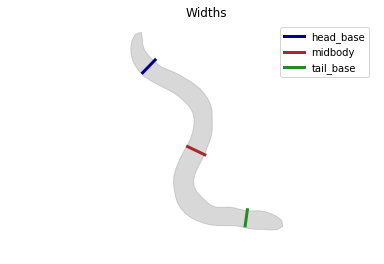

In [5]:
from tierpsy_features.postures import get_widths

segment_widths = get_widths(widths)

tt = 10

cc = contours[tt]
skel = skeletons[tt]
W = widths[tt]

plt.fill(cc[:, 0], cc[:, 1], color='gray', alpha=0.3)

part_k = ('head_base', 'midbody', 'tail_base')
part_c = ('darkblue', 'brown', 'forestgreen')

for k, c in zip(part_k, part_c):

    ind = int(np.round(np.mean(dp.partitions[k])))
    assert ind > 0 and ind < skel.shape[0] -1

    ss = skel[ind]
    dR = skel[ind + 1] - skel[ind - 1]
    #perpendicular slop
    ang = np.arctan2(dR[1], dR[0]) + np.pi/2

    w = W[ind]
    dx =w*np.cos(ang)/2
    dy =w*np.sin(ang)/2

    xx = (ss[0] - dx, ss[0] + dx)
    yy = (ss[1] - dy, ss[1] + dy)
    plt.plot(xx, yy, c, lw=3, label = k)
    
plt.axis('equal')
plt.axis('off')
plt.legend()
plt.title('Widths')

Text(0.5,1,'Axis')

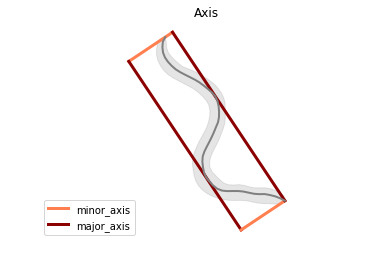

In [7]:
import cv2


cc = contours[tt]
skel = skeletons[tt]



rect = cv2.minAreaRect(skel.astype(np.float32))
box = cv2.boxPoints(rect)

cols = ['coral', 'darkred']
hh = []
for ini, c in enumerate(cols + cols):
    fin = ini+1 if ini <3 else 0
    
    xx,yy = zip(box[ini], box[fin])
    
    h, = plt.plot(xx, yy, c, lw=3)
    hh.append(h)
    
plt.plot(skel[:, 0], skel[:, 1], 'gray', lw=2)
plt.fill(cc[:, 0], cc[:, 1], color='gray', alpha=0.2)

plt.axis('equal')
plt.axis('off')
plt.legend(hh[:2], ['minor_axis', 'major_axis'])
plt.title('Axis')



#quirkiness = np.sqrt(1 - W**2 / L**2)


In [11]:
import tables
from tierpsy_features.postures import EIGEN_PROJECTION_FILE, _angles

with tables.File(EIGEN_PROJECTION_FILE) as fid:
    eigen_worms = fid.get_node('/eigenWorms')[:]
    eigen_worms = eigen_worms.T
    
angles, _ = _angles(skeletons)   
eigen_projections = np.dot(eigen_worms, angles.T)
eigen_projections = np.rollaxis(eigen_projections, -1, 0)



eigen_projections.shape

eigen_worms.shape


(7, 48)